In [2]:
from Functions.polygon_scrape import *
from Functions.trading_strategy import *
import pandas as pd
import numpy as np
from secret import polygon_key
from datetime import datetime, date
import polygon as pg
import warnings
warnings.filterwarnings('ignore')
import time

In [3]:
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
start_date = '2019-01-01'
end_date = '2023-12-31'
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
trading_days = schedule['market_open'].dt.date.tolist()

In [9]:
data = pd.read_csv('Data/More_RV_Features.csv')
returns_data = pd.read_csv('Data/Return_Data.csv').set_index('date')

### Acquire Model Predictions

#### HAR

In [4]:
X = data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly']][-(180+300):].reset_index(drop=True)
Y = data['RV_t (Realized Variance)'][-(180+300):].reset_index(drop=True)

op = RollingWindowHAR(X,Y,data['date'][-(180+300):].reset_index(drop=True))
pred = np.sqrt(op['predictions'].loc['values'])*np.sqrt(365)
df = pd.DataFrame(data=pred,index=data['date'][-180:].reset_index(drop=True))
df.to_csv('Data/predictions_HAR.csv')

#### Random Forests

MSE Optimization

In [5]:
X = data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly',
          'r_(t-1)', 'r_t Weekly', 'r_t Monthly',
          'VIX Close (t-1)', '1MT (t-1)']][-(180+300):].reset_index(drop=True)
Y = data['RV_t (Realized Variance)'][-(180+300):].reset_index(drop=True)

X['1MT (t-1)'] = pd.to_numeric(X['1MT (t-1)'], errors='coerce')
X['1MT (t-1)'] = X['1MT (t-1)'].fillna((X['1MT (t-1)'].shift(+1) + X['1MT (t-1)'].shift(-1)) / 2)

op = RollingWindowRF(X,Y,data['date'][-(180+300):].reset_index(drop=True))
pred = np.sqrt(op['predictions'].loc['values'])*np.sqrt(365)
df = pd.DataFrame(data=pred,index=data['date'][-(180):].reset_index(drop=True))
df.to_csv('Data/predictions_RF.csv')

MAE Optimization

In [6]:
X = X[-(330):]
Y = Y[-(330):]

op = RollingWindowRF(X,Y,data['date'][-(330):].reset_index(drop=True),w=150,method='mae')
pred = np.sqrt(op['predictions'].loc['values'])*np.sqrt(365)

df = pd.DataFrame(data=pred,index=data['date'])[-180:]
df.to_csv('Data/predictions_RF_MAE.csv')

### Import data to avoid long runtime

Comment out the 3 cells above

In [7]:
pred_RF = pd.read_csv('Data/predictions_RF.csv').set_index('date')
pred_RF_MAE = pd.read_csv('Data/predictions_RF_MAE.csv').set_index('date')
pred_HAR = pd.read_csv('Data/predictions_HAR.csv').set_index('date')

### Deploy the Option Strategy Using the Prediction

##### Trade signal based on prediction relative to MEAN

In [8]:
dates = data['date'].iloc[-180:]

[result_HAR_mean,return_HAR_time_mean] = RunStrategy(pred_HAR, dates, trading_days,results_data=returns_data,analysis=True)
[result_RF_mean,return_RF_time_mean] = RunStrategy(pred_RF, dates, trading_days,results_data=returns_data,analysis=True)
[result_RF_MAE_mean,return_RF_MAE_time_mean] = RunStrategy(pred_RF_MAE, dates, trading_days,results_data=returns_data,analysis=True)

Total return from 11/21/22-8/10/23: 2098%. Average daily return: 11.66%. Daily return variance: 90.73. Fraction of days when strategy is bought: 0.6556
Total return from 11/21/22-8/10/23: 1325%. Average daily return: 7.37%. Daily return variance: 91.17. Fraction of days when strategy is bought: 0.5778
Total return from 11/21/22-8/10/23: 1966%. Average daily return: 10.92%. Daily return variance: 90.82. Fraction of days when strategy is bought: 0.6167


##### Trade signal based on prediction relative to MEDIAN

In [9]:
[result_HAR_median,return_HAR_time_median] = RunStrategy(pred_HAR, dates, trading_days,results_data=returns_data,comparison='median',analysis=True)
[result_RF_median,return_RF_time_median] = RunStrategy(pred_RF, dates, trading_days,results_data=returns_data,comparison='median',analysis=True)
[result_RF_MAE_median,return_RF_MAE_time_median] = RunStrategy(pred_RF_MAE, dates, trading_days,results_data=returns_data,comparison='median',analysis=True)

Total return from 11/21/22-8/10/23: 1557%. Average daily return: 8.65%. Daily return variance: 91.06. Fraction of days when strategy is bought: 0.6444
Total return from 11/21/22-8/10/23: 1071%. Average daily return: 5.95%. Daily return variance: 91.28. Fraction of days when strategy is bought: 0.5611
Total return from 11/21/22-8/10/23: 1471%. Average daily return: 8.17%. Daily return variance: 91.11. Fraction of days when strategy is bought: 0.5056


### Examine Results

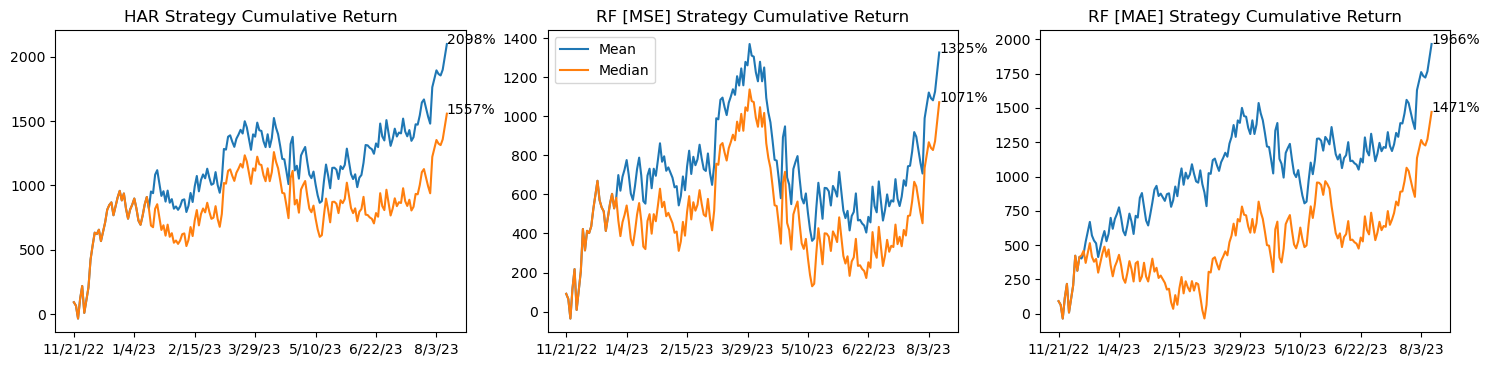

In [10]:
plots = [return_HAR_time_mean,return_RF_time_mean,return_RF_MAE_time_mean,return_HAR_time_median,return_RF_time_median,return_RF_MAE_time_median]
title = ['HAR','RF [MSE]', 'RF [MAE]']

fig, ax = plt.subplots(1,3,figsize=(18,4),dpi=100)

for i in range(3):
    ax[i].plot(dates,plots[i],label='Mean')
    ax[i].plot(dates,plots[i+3],label='Median')
    ax[i].set_xticks(dates[::29])
    ax[i].set_title(f'{title[i]} Strategy Cumulative Return')
    ax[i].annotate(f'{int(plots[i][-1])}%', (dates.iloc[-1],plots[i][-1]))
    ax[i].annotate(f'{int(plots[i+3][-1])}%', (dates.iloc[-1],plots[i+3][-1]))
    if i ==1:
        ax[i].legend()
    
plt.show()

Extract the pulled ATM call/put average IV and the option strategy return

In [11]:
# Results = pd.DataFrame(index=dates, columns=['Avg IV','Return [%]'])

# for i, date in enumerate(dates):
#     if pred_RF_MAE[i] > result_RF_MAE[i]['Results']['Avg IV']:
#         signal = 1
#     else:
#         signal = -1
    
#     Results.loc[date] = [result_RF_MAE[i]['Results']['Avg IV'], float(result_RF_MAE[i]['Return'][:-1]) * signal]

# Results.to_csv('Data/Return_Data.csv')

- Be more precise with choice / explanation of ratio (optimize)
- r is not constant for further one-day out
- annualization to 252 (maybe cancels out now?)
- Case study: sample different parts from time, compare

Next steps:
- Improve Vol estimation

In [18]:
pred_RF_MAE = pd.read_csv('Data/RF_Best_Model_Predictions.csv', index_col=0)
pred_RF_MAE['values'] = np.sqrt(pred_RF_MAE['values'])*np.sqrt(252)

dates = pd.Series(pred_RF_MAE.index)

r = pd.read_csv('Data/EFFR.csv')
r.dropna(axis=0, inplace=True)
r.set_index('date',inplace=True)

In [19]:
np.mean(pred_RF_MAE['values'])

0.12433125827556554

In [20]:
r_data = pd.read_csv('Testing_Files/Archived_Data/return_data_new.csv', index_col=0)

Total return from 11/1/19-8/10/23: $2285.0. Average daily return: 2.43%. Daily return variance: 89.02. Fraction of days when strategy is bought: 0.2274
Total return from 11/1/19-8/10/23: $2062.0. Average daily return: 2.19%. Daily return variance: 89.02. Fraction of days when strategy is bought: 0.1828
Total return from 11/1/19-8/10/23: $2405.0. Average daily return: 2.56%. Daily return variance: 89.01. Fraction of days when strategy is bought: 0.1573
Total return from 11/1/19-8/10/23: $2583.0. Average daily return: 2.74%. Daily return variance: 89.01. Fraction of days when strategy is bought: 0.1445
Total return from 11/1/19-8/10/23: $2621.0. Average daily return: 2.79%. Daily return variance: 89.01. Fraction of days when strategy is bought: 0.1265
Total return from 11/1/19-8/10/23: $2656.0. Average daily return: 2.82%. Daily return variance: 89.0. Fraction of days when strategy is bought: 0.1084
Total return from 11/1/19-8/10/23: $1856.0. Average daily return: 1.97%. Daily return var

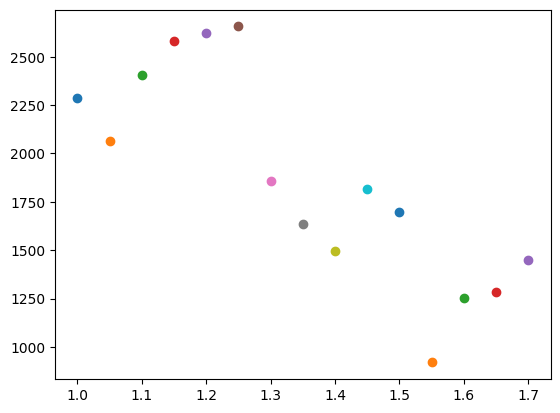

In [54]:
for thresh in np.arange(1,1.75,.05):
    [result_RF_MAE_mean,return_RF_MAE_time_mean] = RunStrategy(HAR_pred, dates, trading_days, r, thresh=thresh, num_strikes=1, analysis=True,comparison='mean',results_data=r_data)
    plt.scatter(thresh, np.sum(r['Return'] for r in result_RF_MAE_mean))

In [55]:
HAR_pred  = pd.read_csv('Data/HAR_Predictions.csv', index_col=0)
[result_HAR,return_HAR_time] = RunStrategy(HAR_pred, dates, trading_days, r, thresh=1.2, num_strikes=1, analysis=True,comparison='mean',results_data=r_data)

Total return from 11/1/19-8/10/23: $2621.0. Average daily return: 2.79%. Daily return variance: 89.01. Fraction of days when strategy is bought: 0.1265


date
11/1/19      22.17
11/4/19     122.17
11/5/19     222.17
11/6/19     189.05
11/7/19     289.05
            ...   
8/4/23     1682.68
8/7/23     1694.07
8/8/23     1649.78
8/9/23     1749.78
8/10/23    1849.78
Name: Return [%], Length: 941, dtype: float64

Total return from 11/1/19-8/10/23: $3548.0. Average daily return: 3.77%. Daily return variance: 88.97. Fraction of days when strategy is bought: 0.1382


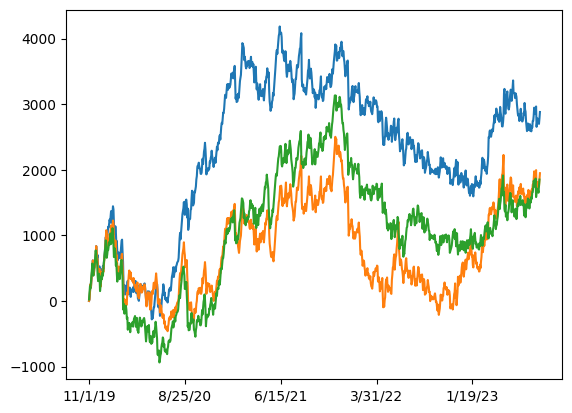

In [60]:
[result_RF_MAE_mean,return_RF_MAE_time_mean] = RunStrategy(pred_RF_MAE, dates, trading_days, r, thresh=1.3, num_strikes=1, analysis=True,comparison='mean',results_data=r_data)
plt.plot(return_RF_MAE_time_mean)
plt.plot(return_HAR_time)
plt.plot(r_data['Return [%]'].cumsum()*-1)
plt.xticks(dates[::200])
plt.show()

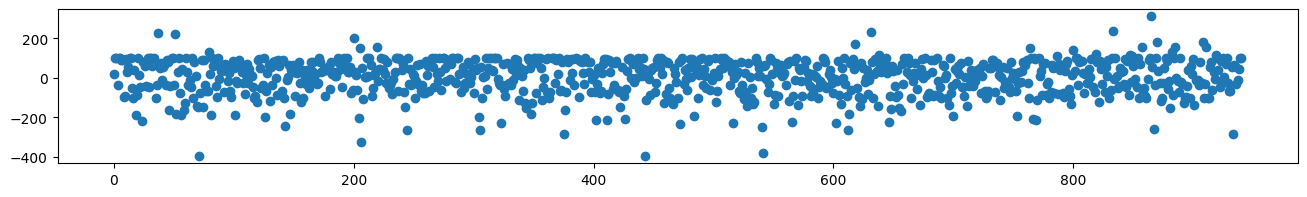

In [7]:
plt.figure(figsize=(16,2))
plt.scatter(range(len(result_RF_MAE_mean)), [r['Return'] for r in result_RF_MAE_mean])

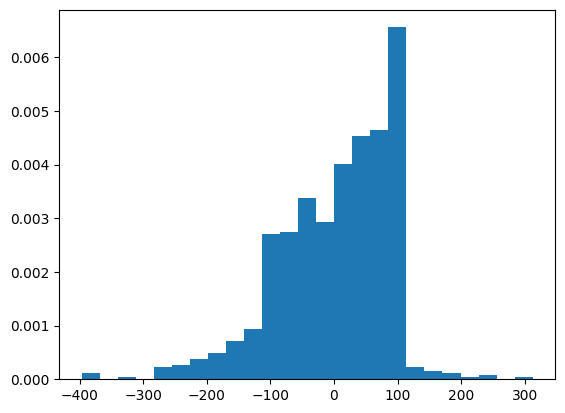

In [49]:
plt.hist([r['Return'] for r in result_RF_MAE_mean], bins=25, density=True)
plt.show()

In [37]:
df = pd.DataFrame([r['Return'] for r in result_RF_MAE_mean], index=dates, columns=['Return'])

In [44]:
df['Cumulative_Return'] = df['Return'].cumsum()

In [46]:
df['Peak'] = df['Cumulative_Return'].cummax()
df['Drawdown'] = df['Cumulative_Return'] - df['Peak']
df['Drawdown_Percentage'] = df['Drawdown'] / df['Peak']

# Maximum drawdown
max_drawdown = df['Drawdown_Percentage'].min()
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')

# Longest drawdown duration
df['End_of_Drawdown'] = df['Drawdown'] == 0
# drawdown_periods = df[df['End_of_Drawdown']].index.to_series().diff().dt.days
# longest_drawdown = drawdown_periods.max()
# print(f'Longest Drawdown Duration: {longest_drawdown} days')

Maximum Drawdown: -108.60%


In [47]:
df

,Return,Cumulative_Return,Peak,Drawdown,Drawdown_Percentage,End_of_Drawdown
date,,,,,,
11/1/19,22.17,22.17,22.17,0.00,0.000000,True
11/4/19,100.00,122.17,122.17,0.00,0.000000,True
11/5/19,100.00,222.17,222.17,0.00,0.000000,True
11/6/19,-33.12,189.05,222.17,-33.12,-0.149075,False
11/7/19,100.00,289.05,289.05,0.00,0.000000,True
...,...,...,...,...,...,...
8/4/23,-28.74,3403.48,4006.19,-602.71,-0.150445,False
8/7/23,-11.39,3392.09,4006.19,-614.10,-0.153288,False
8/8/23,-44.29,3347.80,4006.19,-658.39,-0.164343,False


<Axes: >

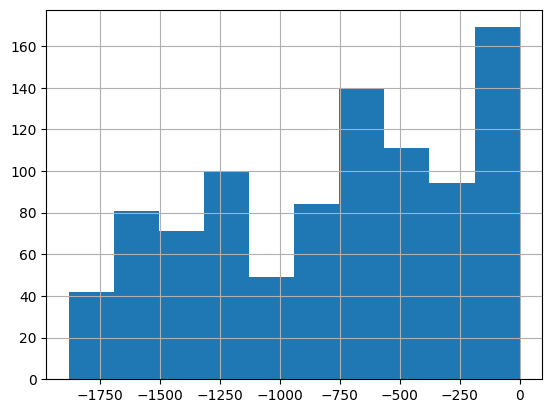

In [51]:
df['Drawdown'].hist()